(quickstart)=

# Quickstart 

In [1]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

The easiest way to get started with using emcee is to use it for a project. To get you started, here’s an annotated, fully-functional example that demonstrates a standard usage pattern.

## How to sample a multi-dimensional Gaussian

We’re going to demonstrate how you might draw samples from the multivariate Gaussian density given by:

$$
p(\vec{x}) \propto \exp \left [ - \frac{1}{2} (\vec{x} -
    \vec{\mu})^\mathrm{T} \, \Sigma ^{-1} \, (\vec{x} - \vec{\mu})
    \right ]
$$

where $\vec{\mu}$ is an $N$-dimensional vector position of the mean of the density and $\Sigma$ is the square N-by-N covariance matrix.

The first thing that we need to do is import the necessary modules:

In [2]:
import numpy as np

Then, we’ll code up a Python function that returns the density $p(\vec{x})$ for specific values of $\vec{x}$, $\vec{\mu}$ and $\Sigma^{-1}$. In fact, emcee actually requires the logarithm of $p$. We’ll call it `log_prob`:

In [3]:
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

It is important that the first argument of the probability function is
the position of a single "walker" (a *N* dimensional
`numpy` array). The following arguments are going to be constant every
time the function is called and the values come from the `args` parameter
of our {class}`EnsembleSampler` that we'll see soon.

Now, we'll set up the specific values of those "hyperparameters" in 5
dimensions:

In [4]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

and where `cov` is $\Sigma$.

How about we use 32 walkers? Before we go on, we need to guess a starting point for each
of the 32 walkers. This position will be a 5-dimensional vector so the
initial guess should be a 32-by-5 array.
It's not a very good guess but we'll just guess a
random number between 0 and 1 for each component:

In [7]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

Now that we've gotten past all the bookkeeping stuff, we can move on to
the fun stuff. The main interface provided by `emcee` is the
{class}`EnsembleSampler` object so let's get ourselves one of those:

In [8]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

Remember how our function `log_prob` required two extra arguments when it
was called? By setting up our sampler with the `args` argument, we're
saying that the probability function should be called as:

In [9]:
log_prob(p0[0], means, cov)

-2.8645313265598875

If we didn't provide any
`args` parameter, the calling sequence would be `log_prob(p0[0])` instead.

It's generally a good idea to run a few "burn-in" steps in your MCMC
chain to let the walkers explore the parameter space a bit and get
settled into the maximum of the density. We'll run a burn-in of 100
steps (yep, I just made that number up... it's hard to really know
how many steps of burn-in you'll need before you start) starting from
our initial guess ``p0``:

In [11]:
state = sampler.run_mcmc(p0, 100,progress=True)
sampler.reset()

100%|██████████| 100/100 [00:00<00:00, 1075.87it/s]


You'll notice that I saved the final position of the walkers (after the
100 steps) to a variable called `state`. You can check out what will be
contained in the other output variables by looking at the documentation for
the {func}`EnsembleSampler.run_mcmc` function. The call to the
{func}`EnsembleSampler.reset` method clears all of the important bookkeeping
parameters in the sampler so that we get a fresh start. It also clears the
current positions of the walkers so it's a good thing that we saved them
first.

Now, we can do our production run of 10000 steps:

In [13]:
sampler.run_mcmc(state, 10000,progress=True);

100%|██████████| 10000/10000 [00:09<00:00, 1059.09it/s]


The samples can be accessed using the {func}`EnsembleSampler.get_chain` method.
This will return an array
with the shape `(10000, 32, 5)` giving the parameter values for each walker
at each step in the chain.
Take note of that shape and make sure that you know where each of those numbers come from.
You can make histograms of these samples to get an estimate of the density that you were sampling:

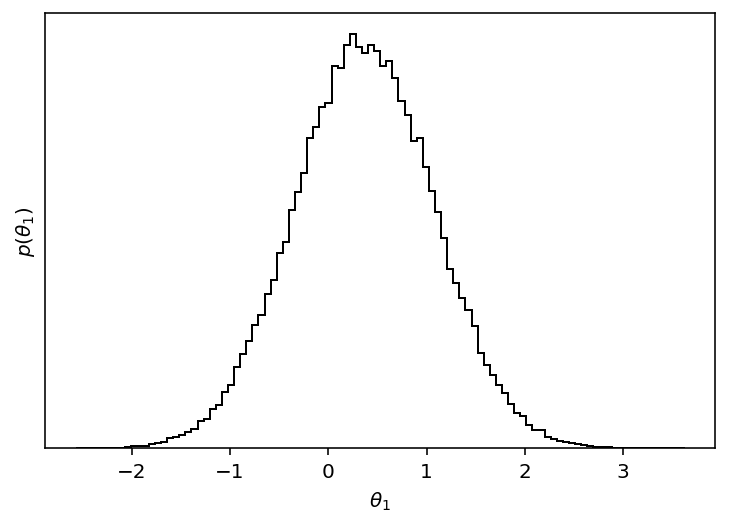

In [14]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

Another good test of whether or not the sampling went well is to check
the mean acceptance fraction of the ensemble using the
{func}`EnsembleSampler.acceptance_fraction` property:

In [15]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.553


and the integrated autocorrelation time (see the {ref}`autocorr` tutorial for more details)

In [16]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean autocorrelation time: 56.991 steps
